### 高斯混合聚类

>高斯混合(*Mixture-of-Gaussian*)聚类采用概率模型来表达聚类原型。

假设 $n$ 维样本空间 $X$ 中的随机向量 $x$ 服从高斯分布，则概率密度函数为：
$$
p(x) = \frac{1}{(2\pi)^\frac{n}{2}|\Sigma|^{\frac{1}{2}}}exp(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu))\\
\mu 为 n 维均值向量\\
\Sigma 为 n\times n 的协方差矩阵\\
$$

高斯混合分布定义为：

$$
p_M(x)=\sum_{i=1}^k\alpha_i·p(x|\mu_i,\Sigma_i)
$$

$k$ 为混合成分个数，每个混合成分对应一个高斯分布。$\alpha_i$为混合系数，满足 $\alpha_i>0，\sum_{i=1}^k\alpha_i=1$

给定训练集 $D={x_1,x_2,...,x_m}$,随机变量 $z_j\in {1,2,3,..,k}$ 表示样本 $x_j$ 的高斯混合成分。根据贝叶斯定理，$z_j$ 的后验分布对应于：

$$
\gamma_{ji} = p_M(z_j|x_j) = \frac{\alpha_i·p(x_j|\mu_i,\Sigma_i)}{\sum_{l=1}^k\alpha_l·p(x_j|\mu_l,\Sigma_l)}
$$

当高斯分布 $\gamma$ 确定时，可将样本集 $D$ 划分为 $k$ 个簇 $C={C_1,C_2,...,C_k}$,簇标记为：
$$
\lambda_j = argmaax\gamma_{ji}
$$

模型参数更新公式：
$$
\mu_i = \frac{\sum_{j=1}^m\gamma_{ji}x_j}{\sum_{j=1}^m\gamma_{ji}}\\
\Sigma_i = \frac{\sum_{j=1}^m\gamma_{ji}(x_j-\mu_i)(x_j-\mu_i)^T}{\sum_{j=1}^m\gamma_{ji}}\\
\alpha_i = \frac{1}{m}\sum_{j=1}^m\gamma_{ji}\\
$$


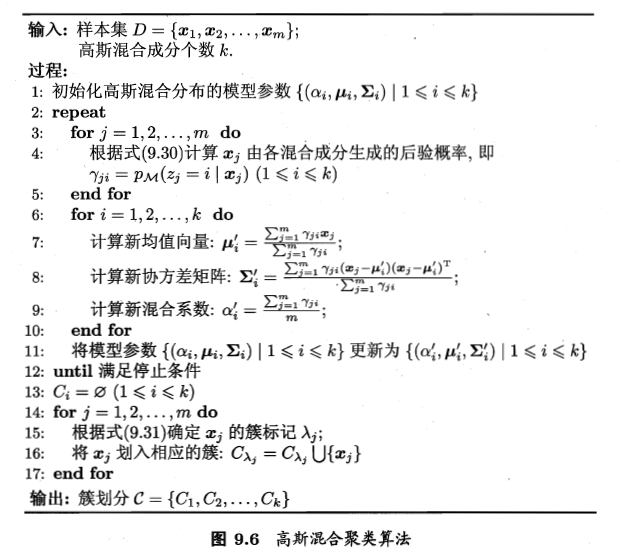

### Code --- 高斯混合聚类

In [1]:
# 导包

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# 对中文的支持
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 加载数据 西瓜数据集4.0

df = pd.read_csv('data4.0.csv')
df

,编号,密度,含糖率
0,1,0.697,0.460
1,2,0.774,0.376
2,3,0.634,0.264
3,4,0.608,0.318
4,5,0.556,0.215
5,6,0.403,0.237
6,7,0.481,0.149
7,8,0.437,0.211
8,9,0.666,0.091
9,10,0.243,0.267


In [248]:
dt = df.iloc[:,1:].to_numpy()
dt.shape

(30, 2)

In [33]:
# 多元高斯分布概率密度函数
def mul_gauss(x,u,sigma):
    """
    x: n 维样本 [x1,x2,...,xn].T
    u: n 维均值向量 [u1,u2,...,un].T
    sigma: n*n 协方差矩阵
    """
    n = len(x)
    
    part1 = ((2*np.pi)**n * np.linalg.det(sigma))**0.5
    part2 = (x-u).T@np.linalg.pinv(sigma)@(x-u)
    p =  np.exp(-part2/2)/part1
    
    return p

In [85]:
# Pm

def Pm(xj,a,u,sigma):
    k = len(a)
    pm = np.zeros((1,k))
    for i in range(k):
        pm[0,i] = a[i]*mul_gauss(xj,u[i],sigma[i])
    
    sum_pm = np.sum(pm)
    pm = pm/sum_pm

    return np.array(pm)

In [241]:
# 高斯混合聚类算法

def MixtureGaus(D,k,expoch):
    """
    D: 不带标签的样本集 {x1,x2,...,xm}
    k: 高斯混合成分个数 
    return: 返回簇划分集合 C={C1，C2,...,Ck}
    """
    cp_D = np.copy(D)
    m = len(cp_D)
    n = cp_D.shape[-1]
    
    # 初始化 ai ui sigma_i {i| 1<=i<=k}
    a = np.ones((k,1))*(1/3)
    arg = [5,21,26]
#     arg = random.sample(range(0, m), k)
    u = cp_D[arg,:]
    s = np.array([[0.1,0.],[0.,0.1]])
    sigma = np.array([s]*k)
    
    gamma = np.zeros((m,k))
    # 迭代
    for step in range(1,expoch+1):
        
        for j in range(m):
            # 计算 xj 由各混合成分生成的后验概率 Pm或gamma_ji
            xj = cp_D[j]
            gamma[j] = Pm(xj,a,u,sigma)
  
        for i in range(k):
            # 计算新的均值向量 ui
            u[i] = (gamma[:,i].T@cp_D)/np.sum(gamma[:,i])

            # 计算新协方差矩阵 sigma
            sigma_tmp = np.zeros((n,n))
            for j in range(m):
                xj = cp_D[j]
                sigma_tmp += gamma[j,i]*(np.matrix(xj-u[i]).T@np.matrix(xj-u[i]))
            
            sigma[i] = sigma_tmp/np.sum(gamma[:,i])

            # 计算新混合系数 ai
            a[i] = np.sum(gamma[:,i])/m
        
    # 簇划分
    C = {}
    # 初始化 C
    for n in range(k):
        C[str(n)] = set()
        
    for j in range(m):
        max_gamma = np.max(gamma[j,:])
        arg = np.argmax(gamma[j,:])
        C[str(arg)].add(j)
    
    return C,u

In [273]:
# show figure
def show(D,C,u,title):
    
    cp = np.copy(D)
    c = ['c', 'b', 'g', 'r', 'm', 'y', 'k', 'w']
    plt.figure()
    for i in range(len(u)):
        x1 = cp[list(C[str(i)]),0]
        x2 = cp[list(C[str(i)]),1]
        plt.scatter(x1, x2, alpha=0.4, c=c[i])
        plt.scatter(u[i, 0], u[i, 1], s=150, alpha=0.9, c=c[i], marker='x')
        plt.xlabel('密度')
        plt.ylabel('含糖率')
        plt.title(title)
    
    plt.legend(['C0','均值向量','C2','均值向量','C3','均值向量'])

In [274]:
C,u = MixtureGaus(dt,3,1)

In [275]:
C,u

({'0': {4, 5, 6, 7, 9, 10, 11, 14, 15, 17, 18, 19, 22},
  '1': {0, 1, 2, 3, 8, 12, 13, 16, 20, 21, 25, 28},
  '2': {23, 24, 26, 27, 29}},
 array([[0.49091163, 0.25101938],
        [0.57124964, 0.28132718],
        [0.53352035, 0.29499597]]))

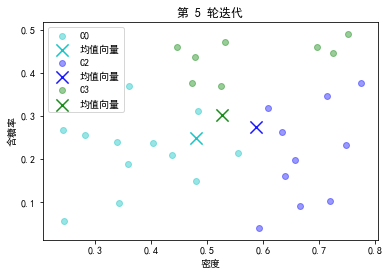

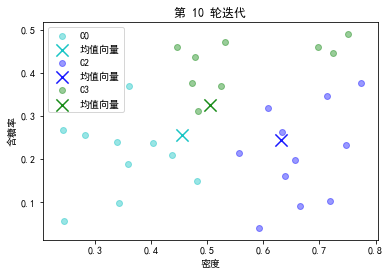

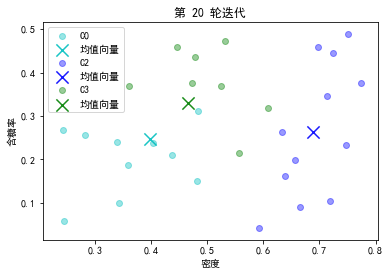

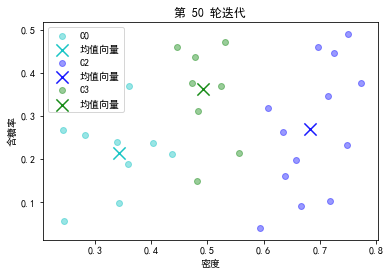

In [276]:
expoch = [5,10,20,50]

for e in expoch:
    C,u = MixtureGaus(dt,3,e)
    title = '第 %d 轮迭代'%e
    show(dt,C,u,title)